In [1]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import sys
import os
from datetime import datetime

from sklearn.metrics import classification_report
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.io import loadmat
import random
import math
from numpy import genfromtxt
import resampy
import matplotlib.pyplot as plt

2022-08-31 03:17:12.853331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
!pip install seaborn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_root = Path("/data/stg60/milton_plotdata")
#data_milton_par = Path("/data/stg60/milton_plotdata/Milton_for_parameter_est/")
data_milton_par = Path("/data/stg60/milton_plotdata/test/FS_Milton0100.tsv")
data_milton_pred=Path("/data/stg60/milton_plotdata/Milton_for_prediction/")

In [39]:
def strides(a, L = 128, S=1):  # Window len = L, Stride len/stepsize = S
    tolist = False
    if isinstance(a, list):
        tolist = True
        a = np.array(a)
    if S is None:
        S = math.ceil(a.size/10)
    nrows = ((a.size - L) // S) + 1
    n = a.strides[0]
    windows = np.lib.stride_tricks.as_strided(a, shape=(nrows, L), strides=(S * n, n))
    
    if tolist:
        windows = windows.tolist()
    return windows
def read_tsv(tsv, start_index = 1024, end_index = None, scale = True):
    dat = genfromtxt(tsv, delimiter='\t')
    x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
    ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
    ang_sin_x_1=(x1-x4)/ell_1
    phi =np.arcsin(ang_sin_x_1)*180/np.pi
    phi = phi.reshape(-1)[start_index:end_index]
    x1 = x1.reshape(-1)[start_index:end_index]
    phi = resampy.resample(phi, sr_orig = 250, sr_new = 100)
    x1 = resampy.resample(x1, sr_orig = 250, sr_new = 100)
    if scale:
        phi = phi/20
        x1 = x1/0.335
    return phi, x1
def prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None, scale = True):
    """AI is creating summary for prepareData

    Args:
        path ([Str]): [path to the original file]
        cutoff (int, optional): [description]. Defaults to 128.
        delay (int, optional): [description]. Defaults to 23.
        L (int, optional): [Window size]. Defaults to 128.
        timetopredict (float, optional): [description]. Defaults to 1.96.
        samplingrate (int, optional): [description]. Defaults to 100.
        fall_stride (int, optional): [description]. Defaults to 1.
        start_index (int, optional): [description]. Defaults to 1024.
        end_index ([type], optional): [description]. Defaults to None.
        scale (bool, optional): [description]. Defaults to True.
    Returns:
        [type]: [description]

    Yields:
        [type]: [description]
    """
    # timetopredict in seconds, note 1 point = 0.01 seconds, or 100points = 1seconds
    def disect(*args, separator = None):
        for arg in args:
            nofall, fall = arg[:-separator], arg[-separator:]
            yield (nofall, fall)
    
    # if path.suffix == ".mat":    
    #     if not isinstance(path, str):
    #         path = path.as_posix()
    #     mat = loadmat(path)
    #     phiv = mat['phiv'].reshape(-1)
    #     dxv = mat['dxv'].reshape(-1)
    #     if scale:
    #         phiv = phiv/20
    #         dxv = dxv/0.335
    # elif path.suffix == ".tsv":
    phiv, dxv = read_tsv(data_milton_par, start_index = start_index, end_index=end_index)

    phiv = phiv[:-cutoff]
    dxv = dxv[:-cutoff]

    #phiv -> delay, respo
    delay_phiv = phiv[delay:]
    respo_phiv = phiv[:-delay]

    #dxv -> delay, respo
    delay_dxv = dxv[delay:]
    respo_dxv = dxv[:-delay]

    #fall region
    fall_region = L + int(timetopredict*samplingrate)
    [(n_delay_phiv, f_delay_phiv), (n_respo_phiv, f_respo_phiv)] = disect(delay_phiv, respo_phiv, separator=fall_region)
    [(n_delay_dxv, f_delay_dxv), (n_respo_dxv, f_respo_dxv)] = disect(delay_dxv, respo_dxv, separator=fall_region)

    if n_delay_phiv.size < f_delay_phiv.size:
        S = 1
    else:
        S = math.ceil((n_delay_phiv.size - f_delay_phiv.size)/(timetopredict*samplingrate+1))

    #s=1 for imbalanced
    # no_fall_windows
    n_delay_phiv = strides(n_delay_phiv, L = L, S = S)
    n_respo_phiv = strides(n_respo_phiv, L = L, S = S)
    n_delay_dxv = strides(n_delay_dxv, L = L, S = S)
    n_respo_dxv = strides(n_respo_dxv, L = L, S = S)

    # fall_windows
    f_delay_phiv = strides(f_delay_phiv, L = L, S = fall_stride)
    f_respo_phiv = strides(f_respo_phiv, L = L, S = fall_stride)
    f_delay_dxv = strides(f_delay_dxv, L = L, S = fall_stride)
    f_respo_dxv = strides(f_respo_dxv, L = L, S = fall_stride)

    # concatenate features
    n_x = np.stack((n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv), -1)
    f_x = np.stack((f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv), -1)

    n_y = np.zeros(n_x.shape[0]).reshape(-1,1)
    f_y = np.ones(f_x.shape[0]).reshape(-1,1)

    x = np.concatenate((n_x,f_x), 0)
    y = np.concatenate((n_y,f_y), 0)

    return x, y, S,n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv,f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv,phiv
    #return x,y,S

In [40]:
x, y, S,n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv,f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv,phiv = prepareData(data_milton_par, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None)
#x, y, S = prepareData(data_milton_par, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None)

In [32]:
len(n_delay_phiv)

207

In [29]:
len(n_delay_phiv)

2811

In [15]:
len(f_respo_dxv)

324

In [33]:
len(f_respo_dxv)

197

In [38]:
np.max(abs(x))

574.9806103586961

In [30]:
len(f_delay_phiv)

197

In [36]:
len(x)

404

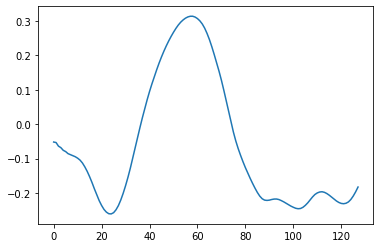

In [41]:
plt.plot(phiv[1:129])